In [1]:
import os
import pandas as pd
import numpy as np
import re
import json
import requests
import time
import seaborn as sns
import matplotlib as plt
from datetime import datetime
from bs4 import BeautifulSoup

In [2]:
def outliers_iqr(data):
    """ Функция для поиска выбросов """
    quartile_1, quartile_3 = np.percentile(data, [25,75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return [lower_bound, upper_bound]

In [3]:
df = pd.read_csv('data\main_task.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
# Уникальные значения признаков
df.nunique(dropna=False)

Restaurant_id        11909
City                    31
Cuisine Style         9008
Ranking              11936
Rating                   9
Price Range              4
Number of Reviews     1460
Reviews              33516
URL_TA               39980
ID_TA                39980
dtype: int64

В датасете только три признака представлены типом float64. Семь признаков типа object. Три признака содержат пропуски.

In [6]:
#Для удобства работы с датасетом, приведём названия колонок к нижнему регистру и заменим пробел на подчеркивание
def rename_col(name):
    return name.lower().replace(' ', '_')    

df.columns = [rename_col(x) for x in df.columns]

In [7]:
df.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta'],
      dtype='object')

In [8]:
print('Всего {}% строк без пропущенных значений'.format(round(df.dropna().shape[0] / df.shape[0]*100),1))

Всего 64% строк без пропущенных значений


Рассмотрим каждый признак по отдельности

#### restaurant_id — идентификационный номер ресторана / сети ресторанов;

In [9]:
# Посмотрим на значения этого признака
df.restaurant_id.value_counts()

id_871      18
id_436      18
id_227      18
id_633      18
id_321      17
            ..
id_9721      1
id_10561     1
id_13621     1
id_10769     1
id_12015     1
Name: restaurant_id, Length: 11909, dtype: int64

In [10]:
df[df.restaurant_id == 'id_436'].head(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
2955,id_436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,4.5,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613
4674,id_436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,4.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362
6118,id_436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,4.5,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...,d9463122
6215,id_436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,4.5,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...,d10438365
7377,id_436,Luxembourg,['Asian'],437.0,4.5,NaN,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...,d743888


Рестораны одной сети имеют одинаковый restaurant_id, но разный id_ta. Стоит отметить, что у каждого ресторана одной сети - одинаковый ranking, то есть оценка распространяется на всю сеть. При этом, каждый ресторан по шкале TA имеет свой рейтинг.

Можно сформировать новый признак - количество ресторанов одной сети.
Есть вероятность, что сетевые рестораны более известные и могут пользоваться большей популярностью.

Можно сформировать новый признак - количество ресторанов одной сети. Есть вероятность, что сетевые рестораны более известные и могут пользоваться большей популярностью.

Но попытки выделить этот признак лишь ухудшали результат.

In [11]:
# counts_rest = dict(df.restaurant_id.value_counts())
# df['network'] = df.restaurant_id.apply(lambda x: counts_rest[x])

#### city — город, в котором находится ресторан;

<AxesSubplot:>

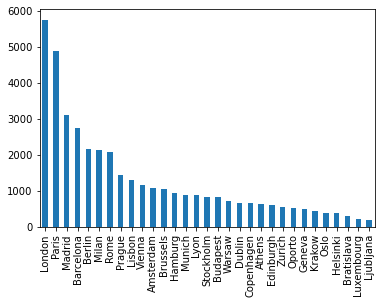

In [12]:
df.city.value_counts().plot.bar()

Больше всего ресторанов в Лондоне и Париже.

Используя признак сity, добавим новые - страны и население.

In [13]:
# Загружаем данные (страны и население) по нужным городам. Eсли файл отсутствует, формируем данные из интернета путём парсинга сайта www.geonames.org.
# Ремарка. Поиск готовых и нужных чистых датасетов в этом случае (31 город), заняло бы больше времени, чем парсинг.
try:
    # Файл, сформированый кодом ниже. Если он отсутствует, то сайт парсится снова
    with open('data/cities.csv', 'r') as f:
        cities = json.load(f)
except:
    # Залить данные с сервиса geonames.org
    cities = dict()
    # Шаблон для парсинга данных в поиске страны
    countries_tmpl = re.compile('countries\/([\w|-]+)\/([\w-]+).html\"\>([\w\s\-]+)\<\/a\>')
    # Шаблон для парсинга данных в поиске населения
    population_tmpl = re.compile('population\s([\d\,]+)<\/small\>')
    # Выбираем нужные города из нашего датасета
    cities_from_df = [city for city in df.city.unique()]
    
    for city in cities_from_df:
        url = 'https://www.geonames.org/search.html?q={}&country='.format(city)
        try:
            html = requests.get(url)
            country = None
            population = None
            # Если ответ успешный, парсим данные
            if html.status_code == 200:
                soup = BeautifulSoup (html.text, 'html.parser')
                # Парсим таблицу с результатом, выбираем первое совпадение (наиболее релевантное)
                match = re.search(countries_tmpl, str(soup.findAll('table', {"class": "restable"})))
                if match:
                    # Сохраняем в формате ('GB', 'united-kingdom', 'United Kingdom')
                    country = match.groups()
                    
                    # Определяем население
                    match = re.search(population_tmpl, str(soup.findAll('table', {"class": "restable"})))
                    if match:
                        population = int(match.group(1).replace(',', ''))
                
                    # Итоговые данные заносим в словарь
                cities[city] = {'country': country, 'population': population}
        except:
            print('Error')
        
        # Чтобы не досить сервер, делаем маленькую паузу
        time.sleep(0.5)

    # Результат сохраняем, чтобы не дёргать ресурс повторно
    try:
        with open('data\cities.csv', 'w') as write_f:
            json.dump(cities, write_f)
    except:
        print('Error writing to file')

In [14]:
# Формируем новый признак - страны
def get_country(city):
    """ Функция принимает на вход город, возвращает страну """
    if city in cities:
        return cities[city]['country'][2]
    else:
        return None
        
df['country'] = df.city.apply(get_country)


In [15]:
# Посмотрим на страны
df.country.value_counts()

United Kingdom    6353
Spain             5842
France            5789
Italy             4211
Germany           3997
Portugal          1813
Czechia           1443
Poland            1170
Austria           1166
Netherlands       1086
Belgium           1060
Switzerland       1019
Sweden             820
Hungary            816
Ireland            673
Denmark            659
Greece             628
Norway             385
Finland            376
Slovakia           301
Luxembourg         210
Slovenia           183
Name: country, dtype: int64

In [16]:
# Формируем новый признак - население
def get_population(city):
    """ Функция принимает на вход город, возвращает количество проживающих человек """
    if city in cities:
        return cities[city]['population']
    else:
        return None
        
df['population'] = df.city.apply(get_population)

In [17]:
df.population.head(5)

0    2138551
1    1515017
2    7556900
3    3442675
4    1260391
Name: population, dtype: int64

In [18]:
# Сформируем ещё один признак (отношение ресторанов в городе к признаку ranking)
rest_counts = dict(df.city.value_counts())
df['rank_k'] = df.apply(lambda x: rest_counts[x.city]/x.ranking, 1)

Признак city не содержит пропусков. Безусловно лидирует Англия, Франция и Испания (Лондон, Париж и Мадрид). Вот куда надо ехать гурманам. На основе этого признака, мы смогли добавить несколько новых. Посмотрим, как повлияют на результат.

#### cuisine_style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

In [19]:
print('Всего {}% строк без пропущенных значений'.format(round(df.cuisine_style.dropna().shape[0] / df.cuisine_style.shape[0]*100),1))

Всего 77% строк без пропущенных значений


In [20]:
# У некоторых кухонь нет значения, обозначим их Other, предварительно сохранив информацию по NaN

In [21]:
df['cuisine_style_isNaN'] = pd.isna(df.cuisine_style).astype('uint8')
df.cuisine_style = df.cuisine_style.fillna("['Other']")

Конвертируем перечень в список

In [22]:
# df['cuisine_list'] = df.cuisine_style.to_list()  # у этого метода возникают пропуски

In [23]:
def cuisines_to_list(cusines_s):
    """ Конвертирует str в список cusines"""
    return [cuisine.strip()[1:-1] for cuisine in cusines_s[1:-1].split(',')]

In [24]:
# Заменяем кухни на список для удобства обработки
# df['cuisine_list'] = df.cuisine_style.to_list() # этот метод теряет часть значений
df['cuisine_list'] = df['cuisine_style'].apply(cuisines_to_list)

In [25]:
# Узнаем, какое количество представлено в датасете
cuisines_set = set()
for cuisines in df['cuisine_list'].dropna():
    for cuisine in cuisines:
        cuisines_set.add(cuisine)
len(cuisines_set)

126

Посмотрим, какая кухня представлена в наибольшем количестве ресторанов

In [26]:
# Словарь для подсчета ресторанов используемых кухонь
cuisines_dict = {x: 0 for x in cuisines_set}

for cuisines in df['cuisine_list'].dropna():
    for cuisine in cuisines:
        cuisines_dict[cuisine] += 1

print(max(cuisines_dict, key=lambda k: cuisines_dict[k]))

Vegetarian Friendly


In [27]:
# Вегетарианцы набирают популярность.

In [28]:
# Сформируем новый признак - количество кухонь, предлагаемых в ресторане
df['cuisine_num'] = df['cuisine_list'].apply(lambda x: len(x))

In [29]:
# Как и предпологалось, cuisine_style, cuisine_list и cuisine_num не содержат пропусков
df[['cuisine_style', 'cuisine_list', 'cuisine_num']].isnull().any()

cuisine_style    False
cuisine_list     False
cuisine_num      False
dtype: bool

In [30]:
# Сколько в среднем кухонь в ресторанах
df.cuisine_num.mean()

2.6224

<AxesSubplot:xlabel='cuisine_num'>

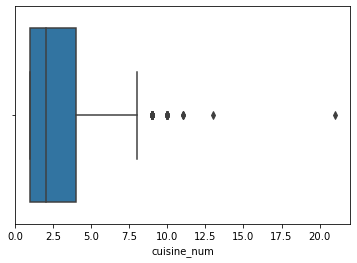

In [31]:
# Посмотрим на выбросы
sns.boxplot(df.cuisine_num)

In [32]:
# Попытка убрать выбросы ухудшила прогноз 
# df = df[df.cuisine_num < outliers_iqr(df.cuisine_num)[1]]
# df.cuisine_num.hist(bins=30)

Итого, в списке представлено 126 видов кухонь, наиболее популярнае из которых - вегетарианская. Неизвестные мы обозначили как Other, тем самым избавившись от пропусков. На основе этих данных мы сформировали новый признак - количество кухонь в ресторане.

#### ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

In [33]:
df.ranking.isna().any()

False

In [34]:
# ranking не содержит пропусков

<AxesSubplot:>

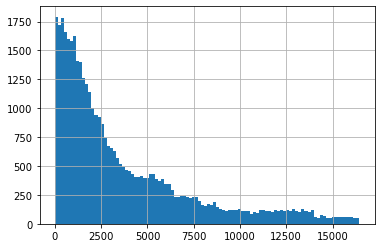

In [35]:
# Посмотрим распределение
df.ranking.hist(bins=100)

In [36]:
# Медиана
df.ranking.median()

2285.0

In [37]:
# Основная часть значений до ~ 2000

<AxesSubplot:xlabel='ranking'>

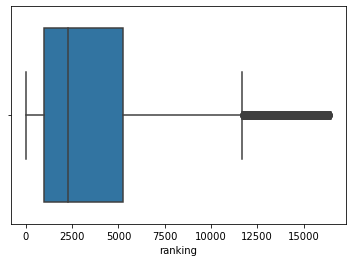

In [38]:
sns.boxplot(df.ranking)

Данный признак не имеет пропусков, а выбросы довольно плотно представлены с правой стороны. Но его модификация сильно влияет на прогноз (пока что, в сторону ухудшения), так как этот признак единственный, кто показывает корреляцию с целевой переменной.

#### rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);

In [39]:
# Основная часть оценок 4 - 4.5
df.rating.value_counts()

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64

<AxesSubplot:>

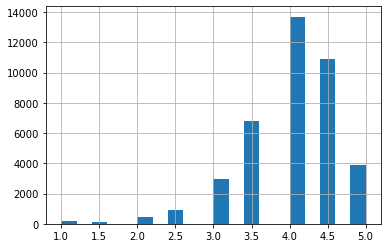

In [40]:
df.rating.hist(bins=20)

#### price_range — диапазон цен в ресторане;

In [41]:
df['price_range'].value_counts(dropna=False)

$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: price_range, dtype: int64

In [42]:
print('Всего {}% строк без пропущенных значений'.format(round(df.price_range.dropna().shape[0] / df.price_range.shape[0]*100),1))

Всего 65% строк без пропущенных значений


In [43]:
# Данный признак можно привести к числовому виду, для использования в прогнозе
price_dict = {
    '$': 0,
    '$$ - $$$': 1,
    '$$$$': 2
}
df['price_range_upd']= df['price_range'].replace(to_replace=price_dict)


In [44]:
df.price_range_upd.value_counts(dropna=False)

1.0    18412
NaN    13886
0.0     6279
2.0     1423
Name: price_range_upd, dtype: int64

In [45]:
# Сохраняем данные о пропусках
df['price_range_upd_isNaN'] = pd.isna(df['price_range_upd']).astype('uint8')

In [46]:
# Заполняем медианой, то есть 1
df['price_range_upd'] = df['price_range_upd'].fillna(1)

<AxesSubplot:>

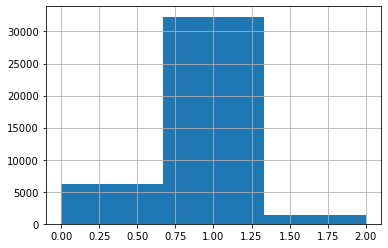

In [47]:
df.price_range_upd.hist(bins=3)

In [48]:
# Основную долю рынка занимают рестораны с средним ценообразованием $$ - $$$.

### number_of_reviews — количество отзывов о ресторане;

In [49]:
df.number_of_reviews.value_counts(dropna=False)

NaN       2543
2.0       1916
3.0       1636
4.0       1370
5.0       1181
          ... 
2123.0       1
1633.0       1
1480.0       1
1924.0       1
1383.0       1
Name: number_of_reviews, Length: 1460, dtype: int64

<AxesSubplot:>

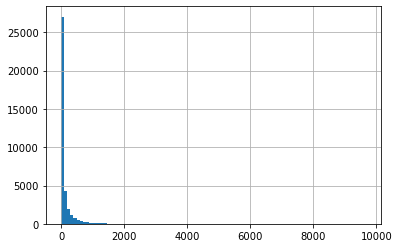

In [50]:
df.number_of_reviews.hist(bins=100)

In [51]:
print('Всего {}% строк без пропущенных значений'.format(round(df.number_of_reviews.dropna().shape[0] / df.number_of_reviews.shape[0]*100),1))

Всего 94% строк без пропущенных значений


In [52]:
# Если данных по отзывам нет, то скорее всего - молодые рестораны.

In [53]:
# Сохраняем NaN
df['number_of_reviews_isNaN'] = pd.isna(df['number_of_reviews']).astype('uint8')

In [54]:
# Заполним пустые значения медианой в разрезе города

In [55]:
def median_by_city(city, column):
    """ Вычисление медианы в разрезе города """
    return df[df.city == city][column].median()

In [56]:
# Сформируем словарь значений, где ключом является город, а значением - медиана признака по этому городу
city_median = {k: median_by_city(k, 'number_of_reviews') for k in df.city.unique() }

In [57]:
city_median

{'Paris': 46.0,
 'Stockholm': 19.0,
 'London': 38.0,
 'Berlin': 16.0,
 'Munich': 29.0,
 'Oporto': 39.5,
 'Milan': 50.0,
 'Bratislava': 10.0,
 'Vienna': 22.0,
 'Rome': 117.0,
 'Barcelona': 34.0,
 'Madrid': 27.0,
 'Dublin': 44.0,
 'Brussels': 28.0,
 'Zurich': 32.0,
 'Warsaw': 17.0,
 'Budapest': 24.0,
 'Copenhagen': 35.0,
 'Amsterdam': 47.0,
 'Lyon': 31.0,
 'Hamburg': 16.0,
 'Lisbon': 31.0,
 'Prague': 20.0,
 'Oslo': 28.0,
 'Helsinki': 20.0,
 'Edinburgh': 73.0,
 'Geneva': 31.0,
 'Ljubljana': 18.5,
 'Athens': 20.0,
 'Luxembourg': 34.0,
 'Krakow': 28.0}

In [58]:
# Заполняем пустые значения
df.number_of_reviews = df.apply(lambda x: city_median[x.city] if pd.isna(x.number_of_reviews) else x.number_of_reviews, 1)

<AxesSubplot:>

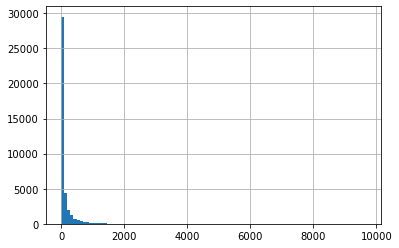

In [59]:
df.number_of_reviews.hist(bins=100)

<AxesSubplot:>

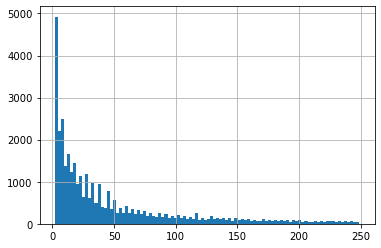

In [60]:
# Посмотрим как выглядит гистограмма, отфильтровав верхние выбросы
df[df.number_of_reviews < outliers_iqr(df.number_of_reviews)[1]].number_of_reviews.hist(bins=100) 

<AxesSubplot:xlabel='number_of_reviews'>

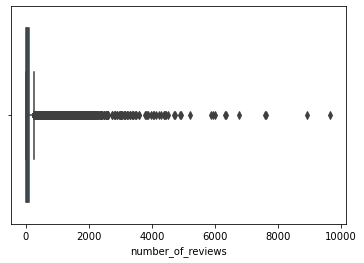

In [61]:
sns.boxplot(df.number_of_reviews)

In [62]:
# Жуткие выбросы

In [63]:
# Определим пороги выбросов
outliers_iqr(df.number_of_reviews)

[-134.0, 250.0]

In [64]:
# Если отсеять данные, то потеряем довольно много записей.
len(df[df.number_of_reviews > outliers_iqr(df.number_of_reviews)[1]])

4794

Наибольшее количество ресторанов имеют до 50 отзывов. Количество отзывов о ресторане может служить важной информацией при прогнозировании. При этом, отсеивание выбросов такого количества может значительно повлиять на результат. Пока оставим.

#### reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

In [65]:
df.reviews.value_counts()

[[], []]                                                                                                      6471
[['Good Lebanese food', 'Decent place'], ['07/19/2017', '03/17/2017']]                                           2
[['The real codido madrileño'], ['03/31/2017']]                                                                  2
[['Very good all around', 'Our first Madrid restaurant'], ['11/20/2017', '10/11/2017']]                          2
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]                                2
                                                                                                              ... 
[['Terrible.', 'This place has really gone downhill'], ['10/28/2017', '08/20/2017']]                             1
[['Great atmosphere and really good service!', 'Excellent food'], ['02/26/2018', '02/23/2018']]                  1
[['Authentic Restaurants', 'I am afraid to write a review because this...'], ['0

In [66]:
# Более 6К ресторанов не имеют отзывов.

In [67]:
# Нас интересуют даты последних отзывов. Мы можем использовать фильтр, чтобы определить последнюю, или разницу между двумя датами.
template_1dt = re.compile("'(\d\d\/\d\d\/\d{4})'")
# Для вычисления дельты
template_2dt = re.compile("'(\d\d\/\d\d\/\d{4})', '(\d\d\/\d\d\/\d{4})'")

In [68]:
def date_from_review(date_string):
    """ Преобразование строки в datetime """
    date = datetime.strptime(date_string, '%m/%d/%Y')
    return date

In [69]:
def get_last_date_review(review):
    """ Извлечение последней даты из отзыва колонки Reviews """
    if pd.notnull(review):
        match = re.search(template_1dt, review)
        if match:
            return date_from_review(match.group(1))
    return None

In [70]:
# Дата последнего отзыва (первая в reviews), datetime
df['review_last'] = df['reviews'].apply(get_last_date_review)

<AxesSubplot:>

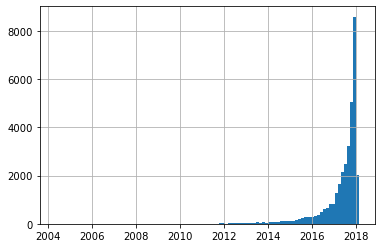

In [71]:
df['review_last'].hist(bins=100)

In [72]:
df['review_last'].min()

Timestamp('2004-04-21 00:00:00')

In [73]:
# Попались рестораны с последним отзывом 2004 года. Есть вероятность, что уже и не функционируют.
# Возможно стоит отфильтровать слишком старые, но попытка убрать - ухудшила прогноз

In [74]:
def get_delta_review(review):
    """ Возвращает разницу в днях между отзывами колонки Reviews """
    if pd.notnull(review):
        match = re.search(template_2dt, review)
        if match:
            # Дата последнего отзыва
            dt_1 = date_from_review(match.group(1))
            # Дата предпоследнего отзыва
            dt_2 = date_from_review(match.group(2))
            # Дельта
            delta = np.abs(dt_1 - dt_2)
            return delta.days
    # Есть признаки, где только одна дата. Поэтому, получим больше None.
    return None

In [75]:
# Разница между отзывами (в днях)
df['review_delta'] = df['reviews'].apply(get_delta_review)

<AxesSubplot:>

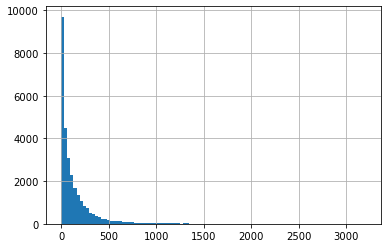

In [76]:
df['review_delta'].hist(bins=100)

<AxesSubplot:>

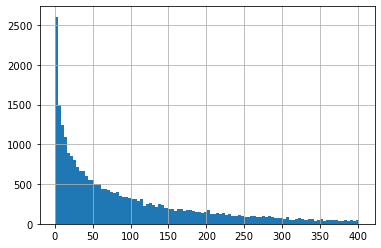

In [77]:
# Чуть увеличим
df[df.review_delta < outliers_iqr(df.review_delta.dropna())[1]].review_delta.hist(bins=100)

In [78]:
# Заполним NaN медианой
review_delta_median = df['review_delta'].median()

In [79]:
# Сохраним значения NaN отдельно
df['review_delta_isNaN'] = pd.isnull(df.review_delta).astype('uint8')

In [80]:
# Заменяем медианой
df['review_delta'].fillna(review_delta_median, inplace=True)

<AxesSubplot:>

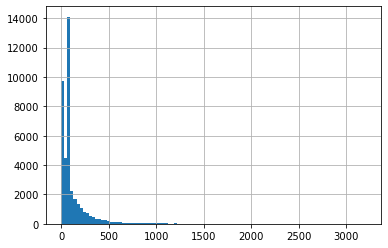

In [81]:
df['review_delta'].hist(bins=100)

Посчитаем разницу между последним отзывом и текущем временем.

In [82]:
# Зафиксируем дату, чтобы получать относительно стабильный результат
today = datetime(2020, 10, 18)

In [83]:
def review_diff_now(date_review):
    """ Возвращает разницу последнего отзыва с настоящим временем, в днях """
    delta = today - date_review
    return delta.days

In [84]:
df['reviews_last_diff'] = df.apply(lambda x: review_diff_now(x['review_last']), 1)

In [85]:
df['reviews_last_diff'].value_counts(dropna=False)

NaN       6471
1015.0     486
1019.0     433
1016.0     396
1014.0     377
          ... 
2786.0       1
2472.0       1
2484.0       1
3344.0       1
2859.0       1
Name: reviews_last_diff, Length: 1881, dtype: int64

In [86]:
# Избавимся от NaN, предварительно сохранив о них информацию
df['reviews_last_diff_isNaN'] = pd.isna(df.reviews_last_diff).astype('uint8')

In [87]:
# Заполним max
df.reviews_last_diff = df.reviews_last_diff.fillna(df.reviews_last_diff.max())

<AxesSubplot:>

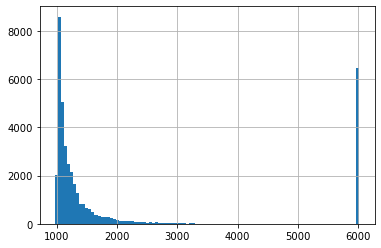

In [88]:
# Образовались аутсайдеры
df.reviews_last_diff.hist(bins=100)

Много отзывов отсутствует, многие содержат только одну дату. Мы постарались извлечь из этого информацию, сформировав два новых признака: Дельта от последнего отзыва до текущих дней и разницу между двумя ближайшими последними отзывами.




### id_ta — идентификатор ресторана в базе данных TripAdvisor.

In [89]:
df.id_ta.value_counts()

d7342803     2
d13002276    2
d9877640     2
d7337366     2
d9802625     2
            ..
d1554191     1
d4988076     1
d8729343     1
d12447364    1
d10061930    1
Name: id_ta, Length: 39980, dtype: int64

In [90]:
df[df.id_ta == 'd8753348']

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,...,cuisine_list,cuisine_num,price_range_upd,price_range_upd_isNaN,number_of_reviews_isNaN,review_last,review_delta,review_delta_isNaN,reviews_last_diff,reviews_last_diff_isNaN
13942,id_1103,Madrid,['Spanish'],1104.0,4.5,$$ - $$$,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348,...,[Spanish],1,1.0,0,0,2017-12-20,67.0,1,1033.0,0
31238,id_1212,Madrid,['Spanish'],1213.0,4.5,$$ - $$$,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348,...,[Spanish],1,1.0,0,0,2017-12-20,67.0,1,1033.0,0


In [91]:
# Похоже, что есть незначительные ошибки в данных этого признака. Удаляем дубликаты.

In [92]:
# Мало признаков коррелирующие с целевой переменной. Но многие, лучше коррелируют с ranking.
df.corr()

,ranking,rating,number_of_reviews,population,rank_k,cuisine_style_isNaN,cuisine_num,price_range_upd,price_range_upd_isNaN,number_of_reviews_isNaN,review_delta,review_delta_isNaN,reviews_last_diff,reviews_last_diff_isNaN
ranking,1.000000,-0.368371,-0.218678,0.559914,-0.060076,0.147995,-0.320250,-0.026525,0.233043,0.094078,0.091467,0.148478,0.138724,0.106386
rating,-0.368371,1.000000,0.027849,-0.037007,0.057244,-0.038263,0.120059,-0.028588,-0.064567,0.008386,-0.070799,-0.014332,-0.041325,-0.024727
number_of_reviews,-0.218678,0.027849,1.000000,-0.006783,0.119255,-0.196823,0.401719,0.108577,-0.260214,-0.078522,-0.127777,-0.215481,-0.188839,-0.154844
population,0.559914,-0.037007,-0.006783,1.000000,0.007217,-0.029095,0.022272,-0.000935,-0.025612,0.001363,-0.039528,-0.137550,-0.134724,-0.126453
rank_k,-0.060076,0.057244,0.119255,0.007217,1.000000,-0.034501,0.087315,0.034342,-0.045752,-0.016948,-0.033120,-0.038927,-0.035560,-0.027916
cuisine_style_isNaN,0.147995,-0.038263,-0.196823,-0.029095,-0.034501,1.000000,-0.490787,0.158268,0.753881,0.186118,0.042113,0.359266,0.295445,0.272140
cuisine_num,-0.320250,0.120059,0.401719,0.022272,0.087315,-0.490787,1.000000,0.003177,-0.566692,-0.175335,-0.184014,-0.393607,-0.341548,-0.286146
price_range_upd,-0.026525,-0.028588,0.108577,-0.000935,0.034342,0.158268,0.003177,1.000000,0.209937,0.040268,-0.030718,0.063775,0.080107,0.079144
price_range_upd_isNaN,0.233043,-0.064567,-0.260214,-0.025612,-0.045752,0.753881,-0.566692,0.209937,1.000000,0.266923,0.074536,0.514967,0.460253,0.414213
number_of_reviews_isNaN,0.094078,0.008386,-0.078522,0.001363,-0.016948,0.186118,-0.175335,0.040268,0.266923,1.000000,-0.073761,0.422352,0.343832,0.329887


In [93]:
# Создаем dummy переменные из признака city
data_with_dummies = pd.get_dummies(df, columns=['city'], dtype=float)

In [94]:
# Подчищаем, удалем признаки object и datetime
object_columns = [x for x in data_with_dummies.columns if str(data_with_dummies[x].dtypes) == 'object' or str(data_with_dummies[x].dtypes) == 'datetime64[ns]']
data_with_dummies = data_with_dummies.drop(object_columns, axis=1)

<AxesSubplot:>

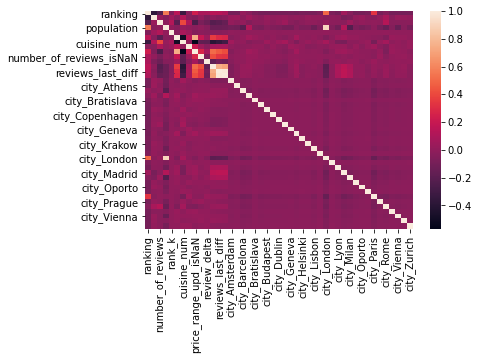

In [95]:
sns.heatmap(data_with_dummies.corr(method="pearson"))

In [96]:
# Нормализация признаков

In [97]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

In [98]:
# for col in data_with_dummies.columns:
#    if col not in ['rating']:
#        data_with_dummies[col] = scaler.fit_transform(pd.DataFrame(data_with_dummies[col]))

## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [99]:
X = data_with_dummies.drop(['rating'], axis = 1)
y = data_with_dummies['rating']

In [100]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [101]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [102]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [103]:
RANDOM_SEED = 42

In [ ]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)


# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# Проверим важные признаки данной модели
plt.rcParams['figure.figsize'] = (10,8)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
# Результат MAE: 0.2047365 - 0.2065444, но можно дожать ещё процентов 10